In [1]:

import axs
import numpy as np

import os
from pyspark.sql.functions import size as spark_size

import altair as alt
import pandas as pd
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
def spark_start(project_path, metastore=None):
    from pyspark.sql import SparkSession

    warehouse_location = os.path.join(project_path, 'spark-warehouse')

    local_dir = os.path.join(project_path, 'spark-tmp')

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[4]")
            .config('spark.driver.memory', '6G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/ctslater")

catalog = axs.AxsCatalog(spark_session)

In [3]:
ztf = catalog.load("ztf_1am_lc")
sesar_axs = catalog.load("sesar_rrlyrae")

In [4]:
%%time
matched = sesar_axs.crossmatch(ztf).drop("axsdist")
results = (matched.select("ra", "dec", "matchid", "Per", "weightedmeanmag", "filterid", "mjd", "psfflux")
                  .where((spark_size(matched['mjd']) > 5) & 
                         ( (matched['S3ab'] > 0.8) | (matched['S3c'] > 0.8))).head(200))

CPU times: user 59.1 ms, sys: 20.8 ms, total: 79.9 ms
Wall time: 1min 51s


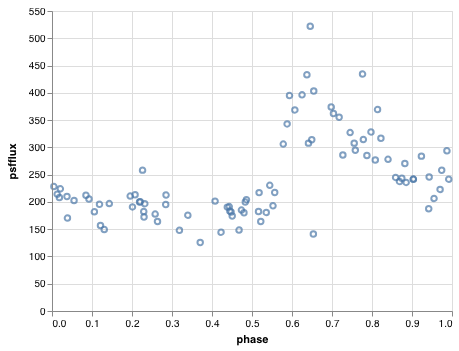

In [5]:
result_id = 5
this_source = results[result_id]
obj_pd = pd.DataFrame(data={x: this_source[x] for x in ['filterid', 'mjd', 'psfflux']})
obj_pd['phase'] = obj_pd['mjd']/this_source['Per'] % 1
alt.Chart(obj_pd).mark_point().encode(x="phase", y="psfflux")